In [36]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 220)

In [29]:
SVR = pd.read_csv('SVR_peak.csv')
SVR['Time'] = pd.to_datetime(SVR['Time'])

#SVR = SVR[(SVR['prev_extrema_value'] <500) & (SVR['next_extrema_value'] <500)]
print(SVR.head())

                 Time  afrr_p    afrr_m  mfrr_p  mfrr_m  mfrr5       SVR  smoothed_SVR  first_derivative  second_derivative  inflection  extrema  time_prev  time_next  amp_diff  prev_extrema_value  next_extrema_value  \
0 2024-09-01 00:00:00     0.0 -41.30751     0.0     0.0    0.0 -41.30751    -41.950752         -1.056096           2.868656         0.0      0.0        NaN        NaN       NaN                 NaN                 NaN   
1 2024-09-01 00:01:00     0.0 -43.78149     0.0     0.0    0.0 -43.78149    -41.509988          1.937623           3.118783         0.0      2.0        NaN        NaN       NaN                 NaN                 NaN   
2 2024-09-01 00:02:00     0.0 -40.60929     0.0     0.0    0.0 -40.60929    -38.075505          5.181470           2.852085         0.0      0.0        NaN        NaN       NaN                 NaN                 NaN   
3 2024-09-01 00:03:00     0.0 -31.30371     0.0     0.0    0.0 -31.30371    -31.147047          7.641794           1.597

In [3]:
def evaluate_predictions(predictions, threshold, use_absolute=False):
    """
    Evaluates the predictions based on a given threshold and optionally uses absolute values for evaluation.
    Computes Mean Squared Error (MSE) for the predictions (excluding True Negatives).

    Parameters:
        predictions (pd.DataFrame): DataFrame with 'actual_value' and 'predicted_value'.
        threshold (float): The threshold value to classify predictions as > threshold or ≤ threshold.
        use_absolute (bool): If True, uses absolute values for both actual and predicted values in calculations.
    """
    # Use absolute values if specified
    if use_absolute:
        predictions['eval_actual_value'] = np.abs(predictions['actual_value'])
        predictions['eval_predicted_value'] = np.abs(predictions['predicted_value'])
    else:
        predictions['eval_actual_value'] = predictions['actual_value']
        predictions['eval_predicted_value'] = predictions['predicted_value']

    # Define the confusion matrix categories
    TP = ((predictions['eval_actual_value'] > threshold) & (predictions['eval_predicted_value'] > threshold)).sum()  # True Positive
    FP = ((predictions['eval_actual_value'] <= threshold) & (predictions['eval_predicted_value'] > threshold)).sum()  # False Positive
    TN = ((predictions['eval_actual_value'] <= threshold) & (predictions['eval_predicted_value'] <= threshold)).sum()  # True Negative
    FN = ((predictions['eval_actual_value'] > threshold) & (predictions['eval_predicted_value'] <= threshold)).sum()  # False Negative

    # Calculate MSE excluding True Negatives
    predictions_non_tn = predictions[(predictions['eval_actual_value'] > threshold) |
                                     (predictions['eval_predicted_value'] > threshold)]
    mse = mean_squared_error(predictions_non_tn['actual_value'], predictions_non_tn['predicted_value'])

    # Create the confusion matrix
    conf_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                               columns=[f'Predicted > {threshold}', f'Predicted ≤ {threshold}'],
                               index=[f'Actual > {threshold}', f'Actual ≤ {threshold}'])

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, linewidths=0.5)
    title_suffix = " (Absolute Values)" if use_absolute else ""
    plt.title(f'Confusion Matrix: Evaluation of Predictions > {threshold}{title_suffix}', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # Additional metrics: Percentage of correct predictions
    total_predictions = TP + TN + FP + FN
    correct_predictions = TP + TN
    percentage_correct = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    # Print results
    print(f"Total predictions (all values): {total_predictions}")
    print(f"Correct predictions (TP + TN): {correct_predictions}")
    print(f"Percentage of correct predictions: {percentage_correct:.2f}%")
    print(f"Mean Squared Error (excluding True Negatives): {mse:.4f}")
    print(f"Mean Standard Deviation Error (excluding True Negatives): {np.sqrt(mse):.4f}")

In [4]:
def plot_filtered_predictions(predictions, start_time='2024-09-01', end_time='2024-09-10'):
    filtered_predictions = predictions[(predictions['predicted_time'] < end_time) & (predictions['predicted_time'] > start_time)]

    plt.figure(figsize=(20, 10))
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['actual_svr_at_predicted_time'],
        label='Actual SVR', alpha=0.5, s=60
    )
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['predicted_value'],
        label='Predicted SVR', color='orange', s=60
    )
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['smoothed_SVR_at_predicted_time'],
        label='Smoothed SVR', color='green', s=60
    )
    plt.title('Prediction of Next Extrema and Time (Filtered)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('SVR', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

In [5]:
def train_model(X, y, NN_model, lr=0.005, patience_early_stop=10, patience_scheduler=5, num_of_epochs=40, peaks=True):
    if peaks:
        title_suffix = "for Peaks"
        checkpoint_path = "weights_peaks.weights.h5"
    else:
        title_suffix = "for Time"
        checkpoint_path = "weights_time.weights.h5"

    # Create a callback to save the model's weights
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,  # Only save the weights
        monitor='val_loss',      # Monitor validation loss
        mode='min',              # Save weights for minimum val_loss
        save_best_only=True,     # Save only the best weights
        verbose=1
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the input data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Compile the model

    NN_model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics=['mse'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_scheduler, min_lr=1e-6)
    history = NN_model.fit(X_train, y_train, validation_split=0.2, epochs=num_of_epochs, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback], verbose=1)

    # Evaluate the model
    test_loss, test_mse = NN_model.evaluate(X_test, y_test)
    print(f"Test Mean Squared Error: {test_mse}")

    # Predict and visualize both outputs
    y_pred = NN_model.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error {title_suffix}: {mse}")


    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel(f'True Values {title_suffix}')
    plt.ylabel(f'Predicted Values {title_suffix}')
    plt.title(f'True vs Predicted Values {title_suffix}')

    plt.tight_layout()
    plt.show()

In [12]:
valid_rows = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                'last_5_SVR_values_5', 'previous_inflections'])
september_rows = valid_rows[valid_rows['Time'] < '2024-09-30 00:00:00']
X = september_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                'last_5_SVR_values_5', 'previous_inflections']].values
y_peak = september_rows[['next_extrema_value']].values  # Two outputs: extrema and time
y_time = september_rows[['time_next']].values

indices = september_rows.index

# Split data into training and testing sets
X_train, X_test, y_peak_train, y_peak_test, y_time_train, y_time_test, train_indices, test_indices = train_test_split(X, y_peak, y_time, indices, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
model_peak = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

Epoch 1/150
212/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140.6456 - mse: 140.6456
Epoch 1: val_loss improved from inf to 71.30077, saving model to weights_peaks.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 139.5950 - mse: 139.5950 - val_loss: 71.3008 - val_mse: 71.3008 - learning_rate: 0.0050
Epoch 2/150
211/221 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.8840 - mse: 94.8840
Epoch 2: val_loss did not improve from 71.30077
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95.0514 - mse: 95.0514 - val_loss: 87.7985 - val_mse: 87.7985 - learning_rate: 0.0050
Epoch 3/150
213/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 129.2212 - mse: 129.2212
Epoch 3: val_loss improved from 71.30077 to 64.05933, saving model to weights_peaks.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 128.9120 - mse: 128.9120 - val_loss: 64.0593 - val_mse: 64.0593 - learning_rate: 0.0050
Epoch 4/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 123.9288 - mse: 123.9288
Epoch 4: val_los

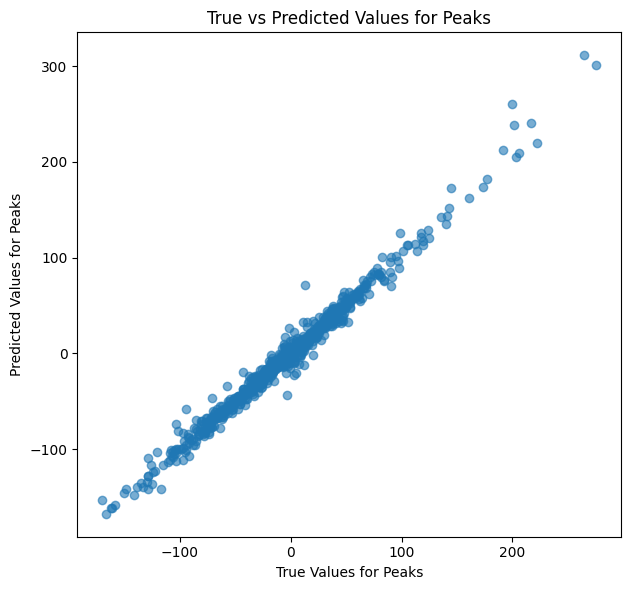

In [437]:
train_model(X, y_peak, model_peak, patience_early_stop=12, patience_scheduler=5, num_of_epochs=150)

In [468]:
model_time = Sequential([
    Input(shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(64),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dense(128),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dropout(0.1),
    Dense(64),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dense(32),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dropout(0.1),
    Dense(1)  # Output layer (no activation needed for regression)
])

Epoch 1/150
201/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3444 - mse: 9.3444
Epoch 1: val_loss improved from inf to 4.03475, saving model to weights_time.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.1025 - mse: 9.1025 - val_loss: 4.0347 - val_mse: 4.0347 - learning_rate: 0.0010
Epoch 2/150
202/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1112 - mse: 4.1112
Epoch 2: val_loss improved from 4.03475 to 3.46613, saving model to weights_time.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0886 - mse: 4.0886 - val_loss: 3.4661 - val_mse: 3.4661 - learning_rate: 0.0010
Epoch 3/150
202/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8029 - mse: 3.8029
Epoch 3: val_loss improved from 3.46613 to 3.29710, saving model to weights_time.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7646 - mse: 3.7646 - val_loss: 3.2971 - val_mse: 3.2971 - learning_rate: 0.0010
Epoch 4/150
200/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3627 - mse: 3.3627
Epoch 4

Test Mean Squared Error: 2.1804349422454834
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error for Time: 2.180435161393109


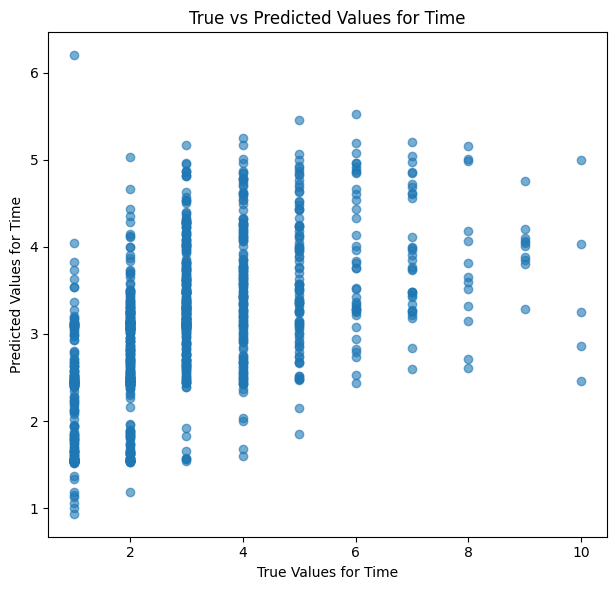

In [9]:
valid_rows = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                'last_5_SVR_values_5', 'previous_inflections'])
september_rows = valid_rows[(valid_rows['Time'] < '2024-09-30 00:00:00')]
X = september_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                'last_5_SVR_values_5', 'previous_inflections']].values
y_peak = september_rows[['next_extrema_value']].values  # Two outputs: extrema and time
y_time = september_rows[['time_next']].values

model_time = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(16),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dropout(0.1),
    Dense(8),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dense(1)  # Output layer (no activation needed for regression)
])


train_model(X, y_time, model_time, lr=0.001, patience_early_stop=12, patience_scheduler=5, num_of_epochs=150, peaks=False)

##Evaluation of model

In [14]:
model_peak.load_weights('/content/weights_peaks.weights.h5')

y_pred_peak1 = model_peak.predict(X_test)
y_pred_peak2 = model_peak.predict(X_train)

y_pred_peak = np.concatenate((y_pred_peak1, y_pred_peak2), axis=0)

y_test_peak = np.concatenate((y_peak_test, y_peak_train), axis=0)

test_indices = np.concatenate((test_indices, train_indices), axis=0)

print(y_pred_peak.shape)
print(y_test_peak.shape)
print(test_indices.shape)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(5519, 1)
(5519, 1)
(5519,)


In [15]:
predictions = pd.DataFrame({
    'actual_value': y_test_peak[:,0],                # Actual extrema value
    'predicted_value': y_pred_peak[:,0],     # Predicted extrema value
    'actual_time': y_time[:,0],                # Actual time to next extrema
    'predicted_time_offset': y_time[:,0],  # Predicted time offset
}, index=test_indices)  # Attach original indices

# Step 4: Calculate predicted time using the original SVR DataFrame
predicted_time_values = (
    SVR.loc[predictions.index, 'Time'] + pd.to_timedelta(predictions['predicted_time_offset'], unit='m')
)
predictions['predicted_time'] = predicted_time_values

# Step 5: Find SVR values at predicted times
actual_svr_at_predicted_time = []
smoothed_svr = []

for predicted_time in predicted_time_values:
    closest_idx = (SVR['Time'] - predicted_time).abs().idxmin()
    actual_svr_at_predicted_time.append(SVR.loc[closest_idx, 'SVR'])
    smoothed_svr.append(SVR.loc[closest_idx, 'smoothed_SVR'])

# Add SVR values to the DataFrame
predictions['actual_svr_at_predicted_time'] = actual_svr_at_predicted_time
predictions['smoothed_SVR_at_predicted_time'] = smoothed_svr

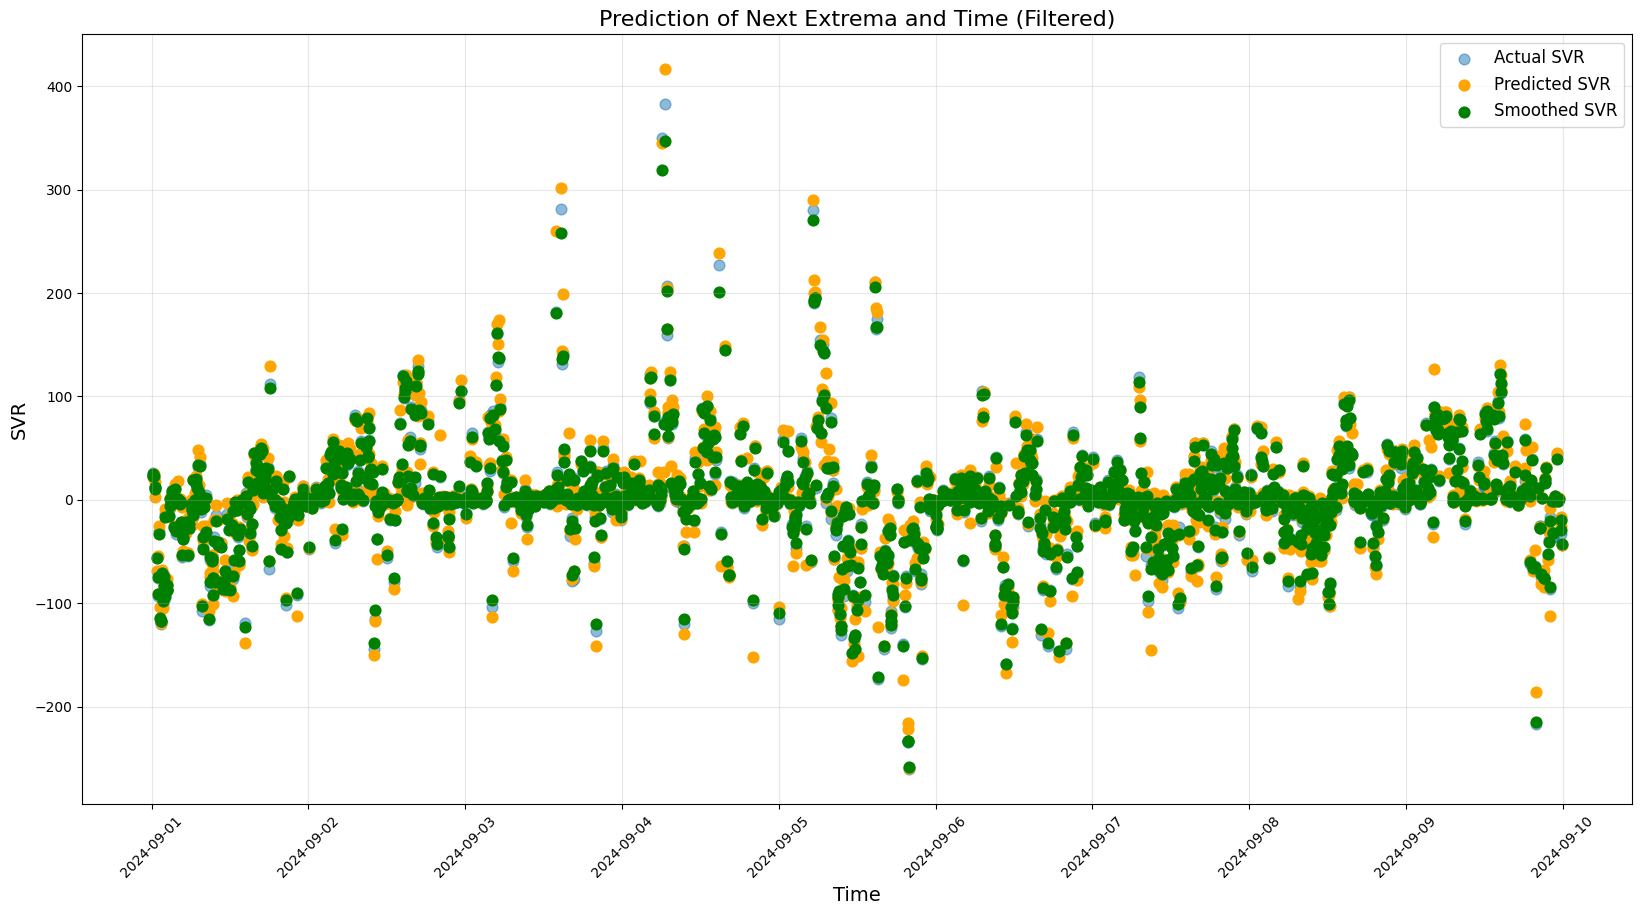

In [16]:
plot_filtered_predictions(predictions)

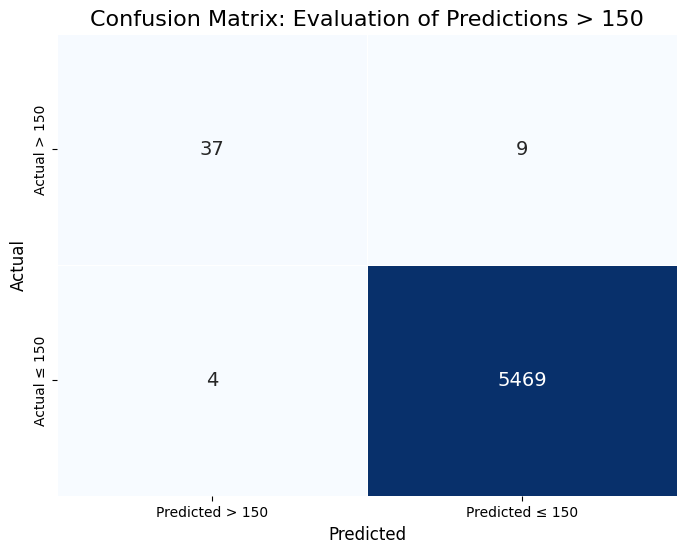

Total predictions (all values): 5519
Correct predictions (TP + TN): 5506
Percentage of correct predictions: 99.76%
Mean Squared Error (excluding True Negatives): 725.2844
Mean Standard Deviation Error (excluding True Negatives): 26.9311


In [17]:
evaluate_predictions(predictions, threshold=150, use_absolute=False)

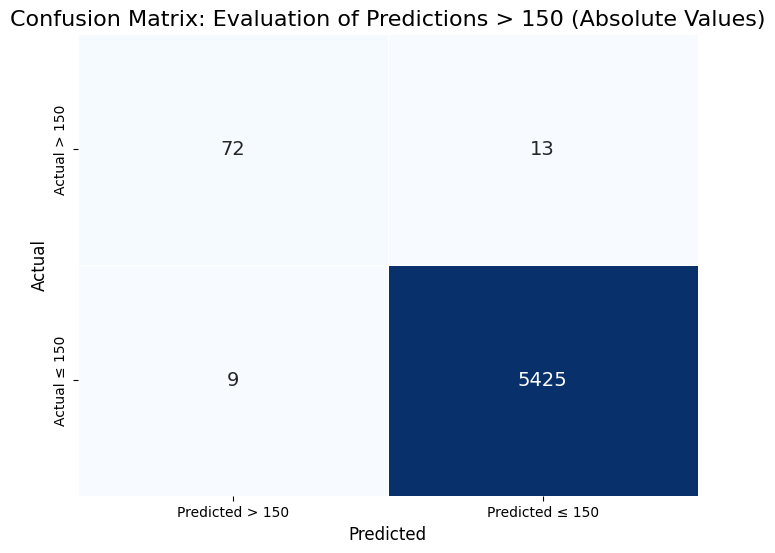

Total predictions (all values): 5519
Correct predictions (TP + TN): 5497
Percentage of correct predictions: 99.60%
Mean Squared Error (excluding True Negatives): 481.6376
Mean Standard Deviation Error (excluding True Negatives): 21.9462


In [18]:
evaluate_predictions(predictions, threshold=150, use_absolute=True)

In [23]:
october_rows = valid_rows[valid_rows['Time'] > '2024-10-01 00:00:00']
X_oct = october_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                'last_5_SVR_values_5', 'previous_inflections']].values
y_oct_val = october_rows[['next_extrema_value']].values  # Two outputs: extrema and time
y_oct_time = october_rows[['time_next']].values

indices_oct = october_rows.index

scaler = StandardScaler()
X_oct = scaler.fit_transform(X_oct)

#model.fit(X_oct, y_oct, epochs=5, batch_size=32, verbose=1)
y_pred_oct = model_peak.predict(X_oct)

print(y_pred_oct.shape)
print(y_oct.shape)
print(indices_oct.shape)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(4525, 1)
(4525, 1)
(4525,)


In [25]:
predictions_oct = pd.DataFrame({
    'actual_value': y_oct_val[:, 0],                # Actual extrema value
    'predicted_value': y_pred_oct[:, 0],     # Predicted extrema value
    'actual_time': y_oct_time[:, 0],                # Actual time to next extrema
    'predicted_time_offset': y_oct_time[:, 0],  # Predicted time offset
}, index=indices_oct)  # Attach original indices

# Step 4: Calculate predicted time using the original SVR DataFrame
predicted_time_values_oct = (
    SVR.loc[predictions_oct.index, 'Time'] + pd.to_timedelta(predictions_oct['predicted_time_offset'], unit='m')
)
predictions_oct['predicted_time'] = predicted_time_values_oct

# Step 5: Find SVR values at predicted times
actual_svr_at_predicted_time_oct = []
smoothed_svr_oct = []

for predicted_time in predicted_time_values_oct:
    closest_idx = (SVR['Time'] - predicted_time).abs().idxmin()
    actual_svr_at_predicted_time_oct.append(SVR.loc[closest_idx, 'SVR'])
    smoothed_svr_oct.append(SVR.loc[closest_idx, 'smoothed_SVR'])

# Add SVR values to the DataFrame
predictions_oct['actual_svr_at_predicted_time'] = actual_svr_at_predicted_time_oct
predictions_oct['smoothed_SVR_at_predicted_time'] = smoothed_svr_oct

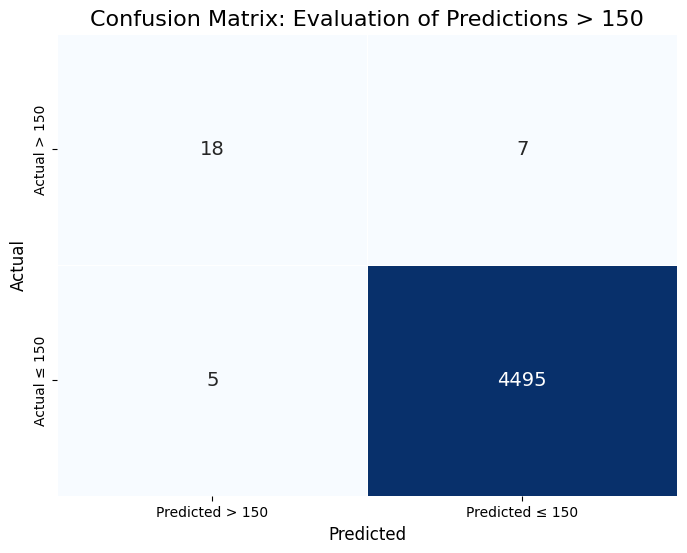

Total predictions (all values): 4525
Correct predictions (TP + TN): 4513
Percentage of correct predictions: 99.73%
Mean Squared Error (excluding True Negatives): 819.7470
Mean Standard Deviation Error (excluding True Negatives): 28.6312


In [26]:
evaluate_predictions(predictions_oct, threshold=150, use_absolute=False)

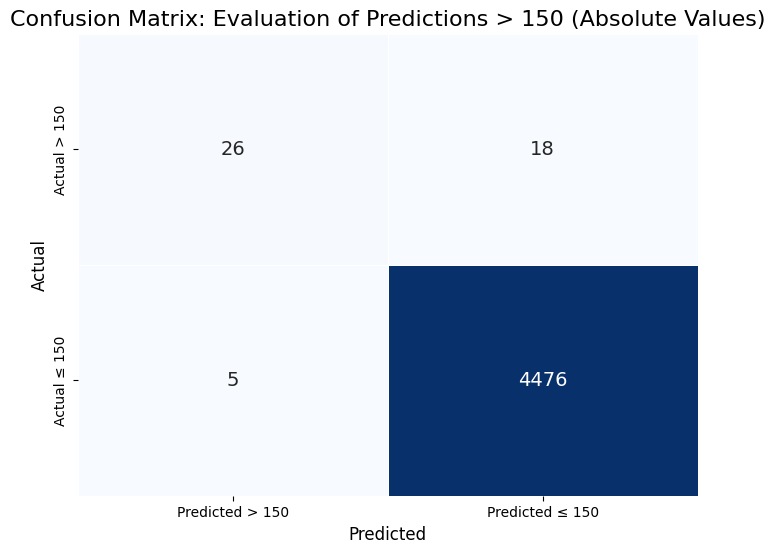

Total predictions (all values): 4525
Correct predictions (TP + TN): 4502
Percentage of correct predictions: 99.49%
Mean Squared Error (excluding True Negatives): 761.9342
Mean Standard Deviation Error (excluding True Negatives): 27.6032


In [27]:
evaluate_predictions(predictions_oct, threshold=150, use_absolute=True)

In [287]:
def visualize_predictions(predictions):
    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(predictions['actual_value'], predictions['predicted_value'], alpha=0.6)
    plt.xlabel('True Extrema Values')
    plt.ylabel('Predicted Extrema Values')
    plt.title('True vs Predicted Extrema Values')

    # Visualize True vs Predicted for Time
    plt.subplot(1, 2, 2)
    plt.scatter(predictions['actual_time'], predictions['predicted_time_offset'], alpha=0.6)
    plt.xlabel('True Time Values')
    plt.ylabel('Predicted Time Values')
    plt.title('True vs Predicted Time Values')

    plt.tight_layout()
    plt.show()

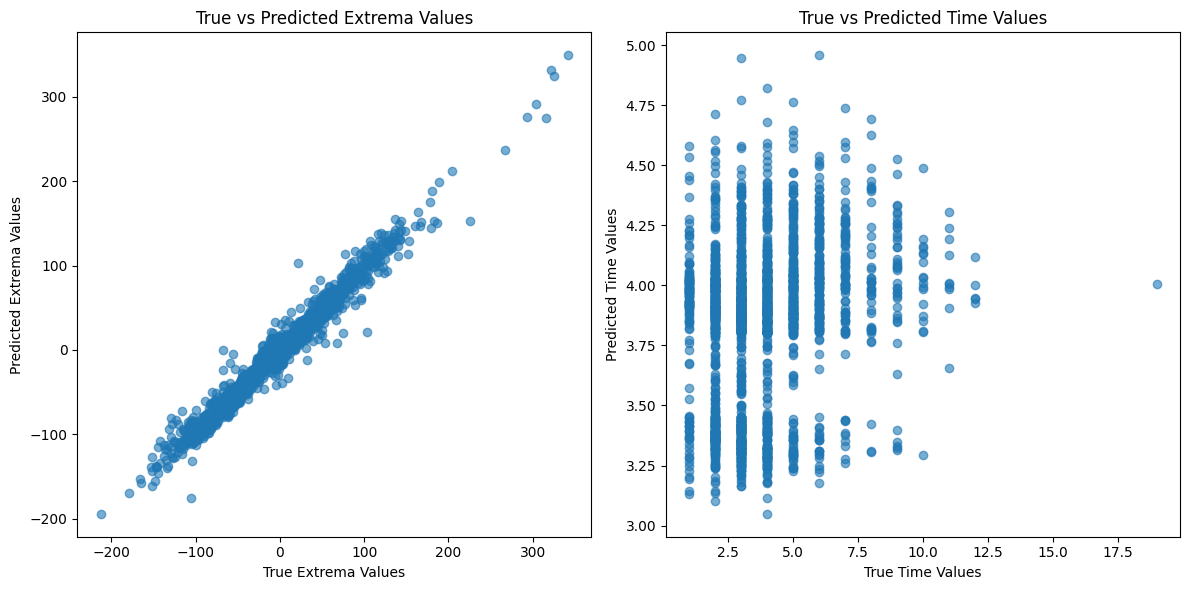

In [288]:
visualize_predictions(predictions_oct)

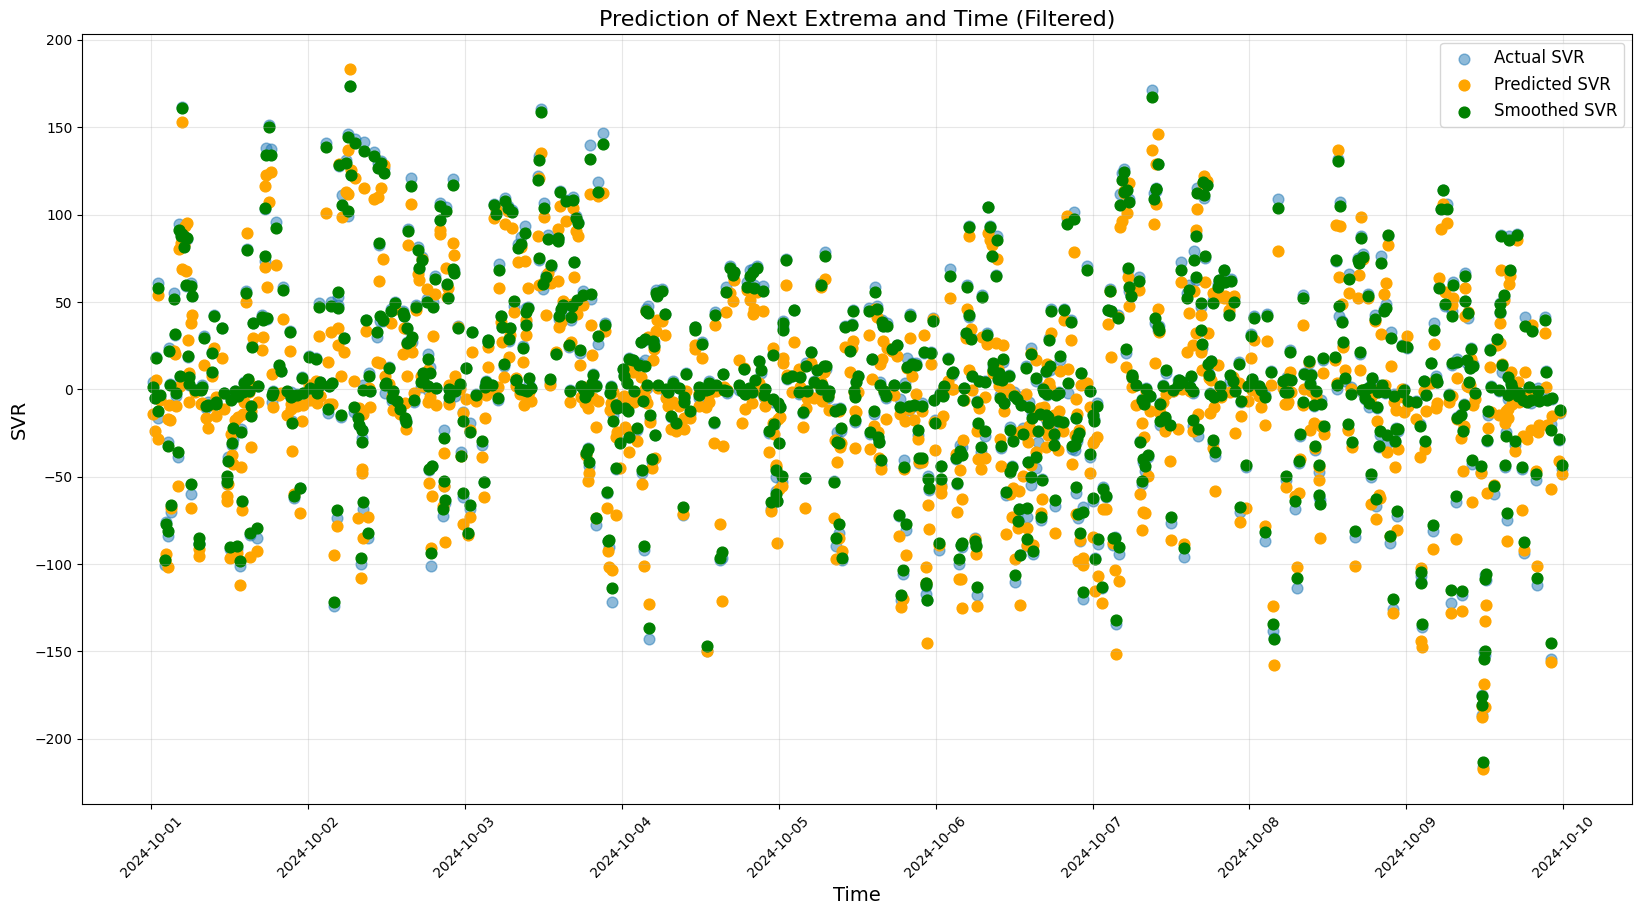

In [297]:
plot_filtered_predictions(predictions_oct, '2024-10-01', '2024-10-10')

#Predicting the sequence

In [49]:
valid_rows_serie = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                      'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                      'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                      'last_5_SVR_values_5', 'previous_inflections'])
september_rows_serie = valid_rows_serie[valid_rows_serie['Time'] < '2024-09-30 00:00:00']
X = september_rows_serie[['time_prev', 'amp_diff', 'prev_extrema_value',
                    'last_5_SVR_values_1', 'last_5_SVR_values_2',
                    'last_5_SVR_values_3', 'last_5_SVR_values_4',
                    'last_5_SVR_values_5', 'previous_inflections']].values
y_serie = september_rows_serie[['next_1_SVR', 'next_2_SVR', 'next_3_SVR', 'next_4_SVR', 'next_5_SVR']].values  # Two outputs: extrema and time

indices = september_rows_serie.index

# Split data into training and testing sets
X_train, X_test, y_serie_train, y_serie_test, train_indices, test_indices = train_test_split(X, y_serie, indices, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model_peak = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

In [ ]:
model = Sequential([
    Input(shape=(1, X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(5)  # Predict the next 5 values
])

In [52]:
def train_LSTM_model(X, y, lr=0.005, patience_early_stop=10, patience_scheduler=5, num_of_epochs=40):
    title_suffix = "for Time"
    checkpoint_path = "serie.weights.h5"

    # Create a callback to save the model's weights
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,  # Only save the weights
        monitor='val_loss',      # Monitor validation loss
        mode='min',              # Save weights for minimum val_loss
        save_best_only=True,     # Save only the best weights
        verbose=1
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the input data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(5)  # Predict the next 5 values
    ])

    # Compile the model

    model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics=['mse'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_scheduler, min_lr=1e-6)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=num_of_epochs, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback], verbose=1)

    # Evaluate the model
    test_loss, test_mse = model.evaluate(X_test, y_test)
    print(f"Test Mean Squared Error: {test_mse}")

    # Predict and visualize both outputs
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error {title_suffix}: {mse}")


    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel(f'True Values {title_suffix}')
    plt.ylabel(f'Predicted Values {title_suffix}')
    plt.title(f'True vs Predicted Values {title_suffix}')

    plt.tight_layout()
    plt.show()

Epoch 1/150
215/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2177.3640 - mse: 2177.3640
Epoch 1: val_loss improved from inf to 643.12720, saving model to serie.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2164.8481 - mse: 2164.8481 - val_loss: 643.1272 - val_mse: 643.1272 - learning_rate: 0.0010
Epoch 2/150
212/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 714.8764 - mse: 714.8764
Epoch 2: val_loss improved from 643.12720 to 246.47188, saving model to serie.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 709.4034 - mse: 709.4034 - val_loss: 246.4719 - val_mse: 246.4719 - learning_rate: 0.0010
Epoch 3/150
210/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 344.5551 - mse: 344.5551
Epoch 3: val_loss improved from 246.47188 to 174.38921, saving model to serie.weights.h5
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 343.9675 - mse: 343.9675 - val_loss: 174.3892 - val_mse: 174.3892 - learning_rate: 0.0010
Epoch 4/150
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

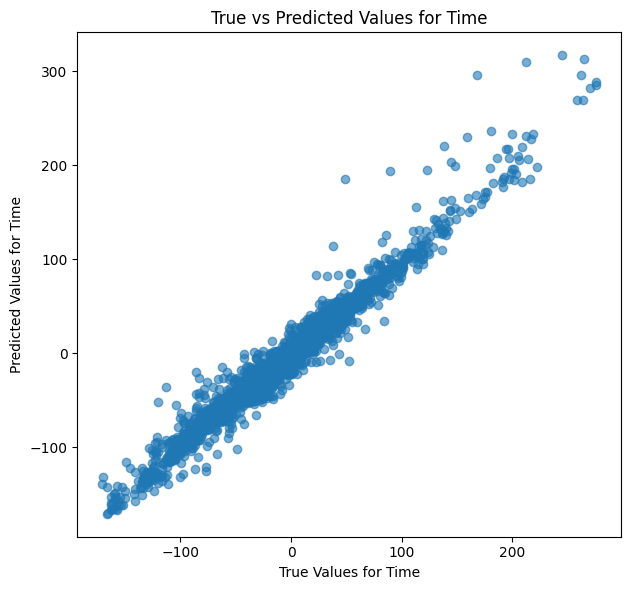

In [54]:
train_LSTM_model(X, y_serie, lr=0.001, patience_early_stop=12, patience_scheduler=5, num_of_epochs=150)

In [55]:
model_serie = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(5)  # Predict the next 5 values
])

model_serie.load_weights('/content/serie.weights.h5')

y_pred_serie = model_serie.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


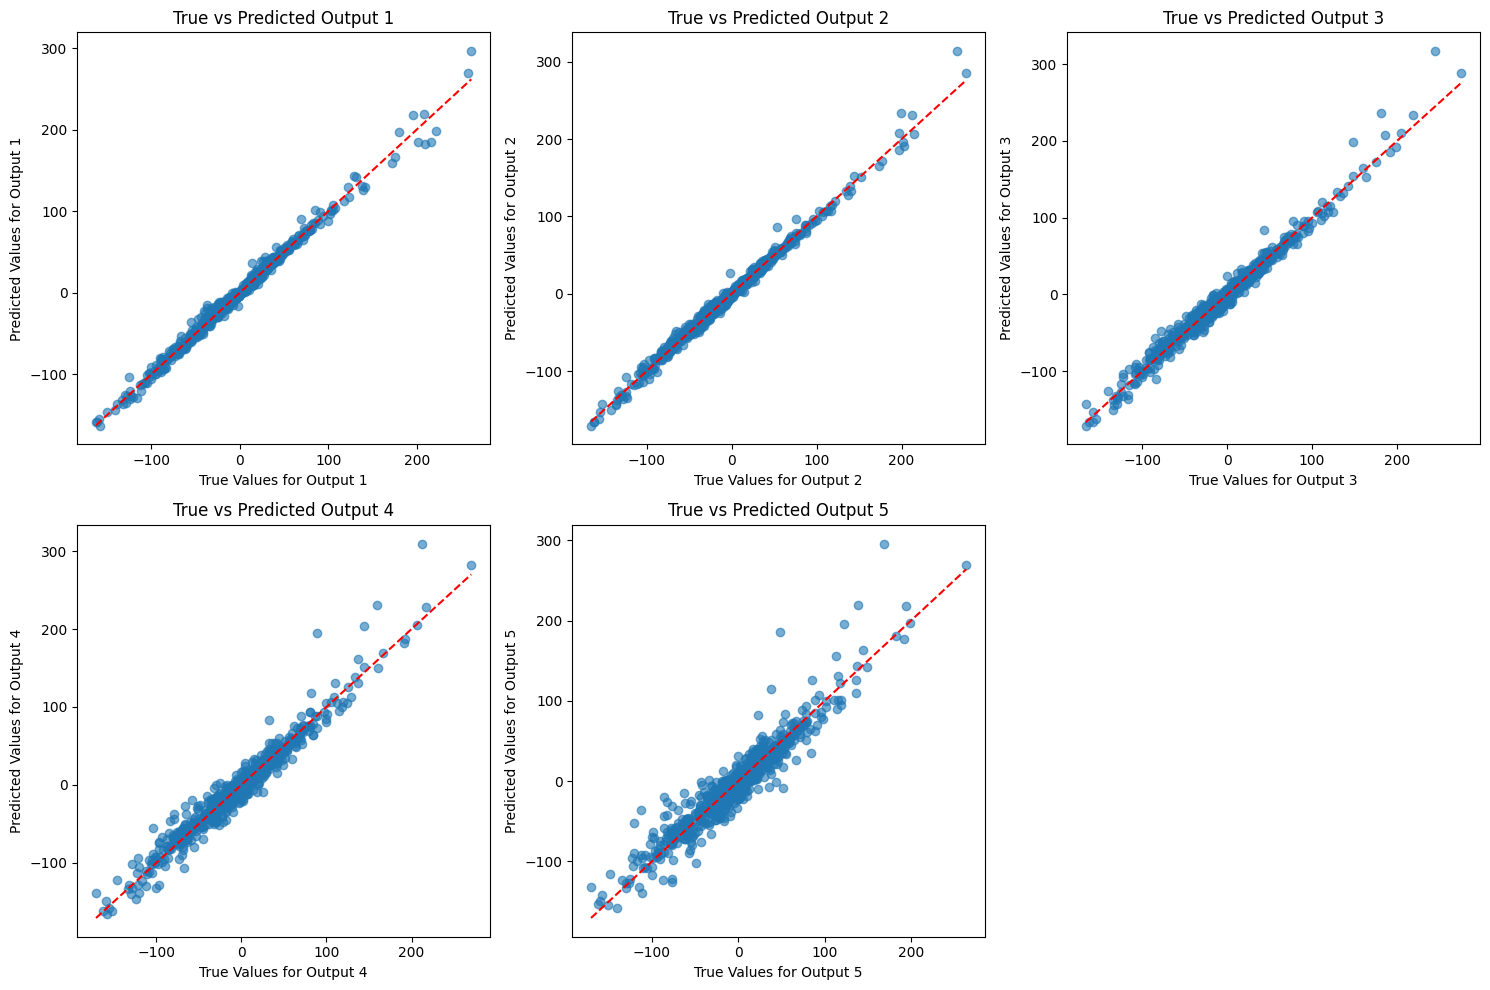

In [56]:
plt.figure(figsize=(15, 10))

# Loop through each dimension of the output
for i in range(5):
    plt.subplot(2, 3, i+1)  # Create subplots for each of the 5 outputs
    plt.scatter(y_serie_test[:, i], y_pred_serie[:, i], alpha=0.6)
    plt.xlabel(f'True Values for Output {i+1}')
    plt.ylabel(f'Predicted Values for Output {i+1}')
    plt.title(f'True vs Predicted Output {i+1}')
    plt.plot([min(y_serie_test[:, i]), max(y_serie_test[:, i])], [min(y_serie_test[:, i]), max(y_serie_test[:, i])], 'r--')  # Ideal line

plt.tight_layout()
plt.show()